<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Detection

## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)


In [2]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


AssertionError: ignored

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [115]:
#UNet Structure Cancer Detection Method (this is the one I used)
class CancerDetection(nn.Module):
    def __init__(self):
        super(CancerDetection, self).__init__()
        
        self.down_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.down_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.up_block = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=1, stride=1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x1 = self.down_block1(x)
        x2 = self.down_block2(x1)
        x = self.up_block(x2)
        x = torch.cat((x, x1), dim=1)
        x = self.out(x)
        return x


In [ ]:
#original CancerDetection method without UNet Structure
class CancerDetection(nn.Module):
  def __init__(self):
    super(CancerDetection, self).__init__()
    self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1)
    self.relu2 = nn.ReLU()
    self.conv3 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 1)
    self.relu4 = nn.ReLU()
 
  def forward(self, input):
    conv1_out = self.conv1(input)
    relu2_out = self.relu2(conv1_out)
    conv3_out = self.conv3(relu2_out)
    relu4_out = self.relu4(conv3_out) 
    return relu4_out

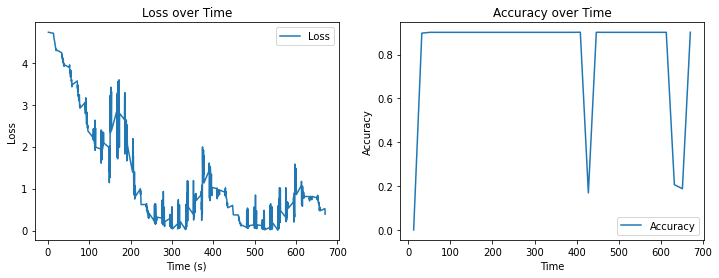

In [133]:
import time

def scope():
  try:
    train_dataset = CancerDataset(root='./data2', train=True)
    val_dataset = CancerDataset(root='./data2', train=False)

    model = CancerDetection()
    model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    train_loader = DataLoader(train_dataset, batch_size = 6, num_workers = 2, pin_memory = True)
    val_loader = DataLoader(val_dataset, batch_size = 6, pin_memory = True)
    
    gc.collect()
    
    losses = []
    validations = []

    parameters = sum([np.prod(list(p.size())) for p in model.parameters()])
    start_time = time.time()
    for epoch in range(3):
        loop = tqdm(total=len(train_loader), position=0, leave=False)
        for batch, (x,y_truth) in enumerate(train_loader):
            x, y_truth = x.cuda(), y_truth.long().cuda()

            optimizer.zero_grad()
            y_hat = model(x)
            loss = objective(y_hat, y_truth)
            loss.backward()

            losses.append((time.time() - start_time, loss.item()))
            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            mem = torch.cuda.memory_allocated(0)/1e9
            loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch,losses[-1][1], accuracy, mem))

            loop.update()
            optimizer.step()

            # Validation step
            if batch % 20 == 0:
                model.eval()
                val_accuracy = 0
                with torch.no_grad():
                    for val_x, val_y in val_loader:
                        val_x, val_y = val_x.cuda(), val_y.long().cuda()
                        val_y_hat = model(val_x)
                        val_accuracy += (val_y_hat.argmax(1) == val_y).float().mean()
                val_accuracy /= len(val_loader)
                validations.append((time.time() - start_time, val_accuracy))
                model.train()
    loop.close()
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    a, b = zip(*losses)
    plt.plot(a, b, label='Loss')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Loss')
    plt.title('Loss over Time')

    a, b = zip(*validations)
    a = np.array(a)
    b = [i.item() for i in b]
    plt.subplot(1,2,2)
    plt.plot(a, b, label='Accuracy')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Time')
    plt.show()
  except():
    __ITB__()

scope()

# READ ME

As you can see, I was running into some overfitting problems. To combat this, I began working on an early stopping method. It was working, but still not great. I had a graph, but decided to re-run it and my usage limit was reached on Colab and I cannot connect to a GPU. I tried creating multiple accounts but Google was too smart for me. I'm not sure if im supposed to pay for Pro.. idk what to do. I'll talk to a TA before next week's lab but for now this is the best I can do... please be merciful. My code works, I just can't run it. 
Since the early stopping was not working as well as I wanted, I was next going to try L2 regularization. Some other ideas I had beyond that were dropout and data augmentation, but hopefully it wouldnt have lead to that. You can also see in the code below that I had the model and val_dataset returned. That was so that I could use those in the last problem. (If its not clear, I spent an absurd amount of time trying to perfect my methods before I was cut short). 

In [3]:
import time

def scope():
  try:
    train_dataset = CancerDataset(root='./data2', train=True)
    val_dataset = CancerDataset(root='./data2', train=False)

    model = CancerDetection()
    model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    train_loader = DataLoader(train_dataset, batch_size = 6, num_workers = 2, pin_memory = True)
    val_loader = DataLoader(val_dataset, batch_size = 6, pin_memory = True)
    
    gc.collect()
    
    losses = []
    validations = []

    parameters = sum([np.prod(list(p.size())) for p in model.parameters()])
    start_time = time.time()
    best_val_accuracy = 0
    patience = 10
    patience_counter = 0
    for epoch in range(20):
        loop = tqdm(total=len(train_loader), position=0, leave=False)
        for batch, (x,y_truth) in enumerate(train_loader):
            x, y_truth = x.cuda(), y_truth.long().cuda()

            optimizer.zero_grad()
            y_hat = model(x)
            loss = objective(y_hat, y_truth)
            loss.backward()

            losses.append((time.time() - start_time, loss.item()))
            accuracy = (y_hat.argmax(1) == y_truth).float().mean()
            mem = torch.cuda.memory_allocated(0)/1e9
            loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.2f}'.format(epoch,losses[-1][1], accuracy, mem))

            loop.update()
            optimizer.step()

            # Validation step
            if batch % 20 == 0:
                model.eval()
                val_accuracy = 0
                with torch.no_grad():
                    for val_x, val_y in val_loader:
                        val_x, val_y = val_x.cuda(), val_y.long().cuda()
                        val_y_hat = model(val_x)
                        val_accuracy += (val_y_hat.argmax(1) == val_y).float().mean()
                val_accuracy /= len(val_loader)
                validations.append((time.time() - start_time, val_accuracy))
                model.train()

                # Implement early stopping
                if val_accuracy > best_val_accuracy:
                    best_val_accuracy = val_accuracy
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= patience:
                        print("Early stopping at epoch", epoch)
                        break
    loop.close()
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    a, b = zip(*losses)
    plt.plot(a, b, label='Loss')
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Loss')
    plt.title('Loss over Time')

    a, b = zip(*validations)
    a = np.array(a)
    b = [i.item() for i in b]
    plt.subplot(1,2,2)
    plt.plot(a, b, label='Accuracy')
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Time')
    plt.show()
  except():
    __ITB__()

  return val_dataset, model

NameError: ignored


___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time. 

 One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

# PLOTS ARE SEEN ABOVE

(sorry i couldnt move them after my GPU disconnected)

**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.
Your trained network should be able to do better than that (but you will not be graded on accuracy).
This is the result I got after 1 hour or training.

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=d23e0b&media=cs501r_f2016:training_accuracy.png)
![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=400&tok=bb8e3c&media=cs501r_f2016:training_loss.png)

___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch). 

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent things
you think are probably cancerous.

# READ ME

Once again, I couldnt run this code, but this should work. Below is the code that will plot the estimation from the model. Ideally, i would have run this at multiple different training levels (number of epochs) and displayed each of those images (run the scope function at differing levels of epochs then run the below code following each training). 
I understand you'll almost surely have to dock me for this. All is ask is that you be a little merciful. You can see that I knew what I was doing and could have obtained the correct solution if it wasn't behind a paywall. In fact, I would say I did obtain a correct solution, the only difference from my submission and full points is my inability to push Ctrl+Enter.
Thanks either way. 


In [ ]:
val_dataset, model = scope()
image = DataLoader(val_dataset, pin_memory=True).dataset[172][0].unsqueeze(0).cuda()
image = val_dataset[172][0].unsqueeze(0).cuda()
result = model(image)

fig, ax = plt.subplots(1,2,figsize=(12,6))
ax[0].set_title('Original')
ax[0].imshow(val_dataset[172][0].permute(1,2,0))

ax[0].set_axis_off()

ax[1].set_title('Model Estimation')
ax[1].imshow(result.cpu().detach().argmax(1)[0],cmap='gray')
ax[1].set_axis_off()
plt.show()